/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_57249/1947073131.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.13, 1, 1])


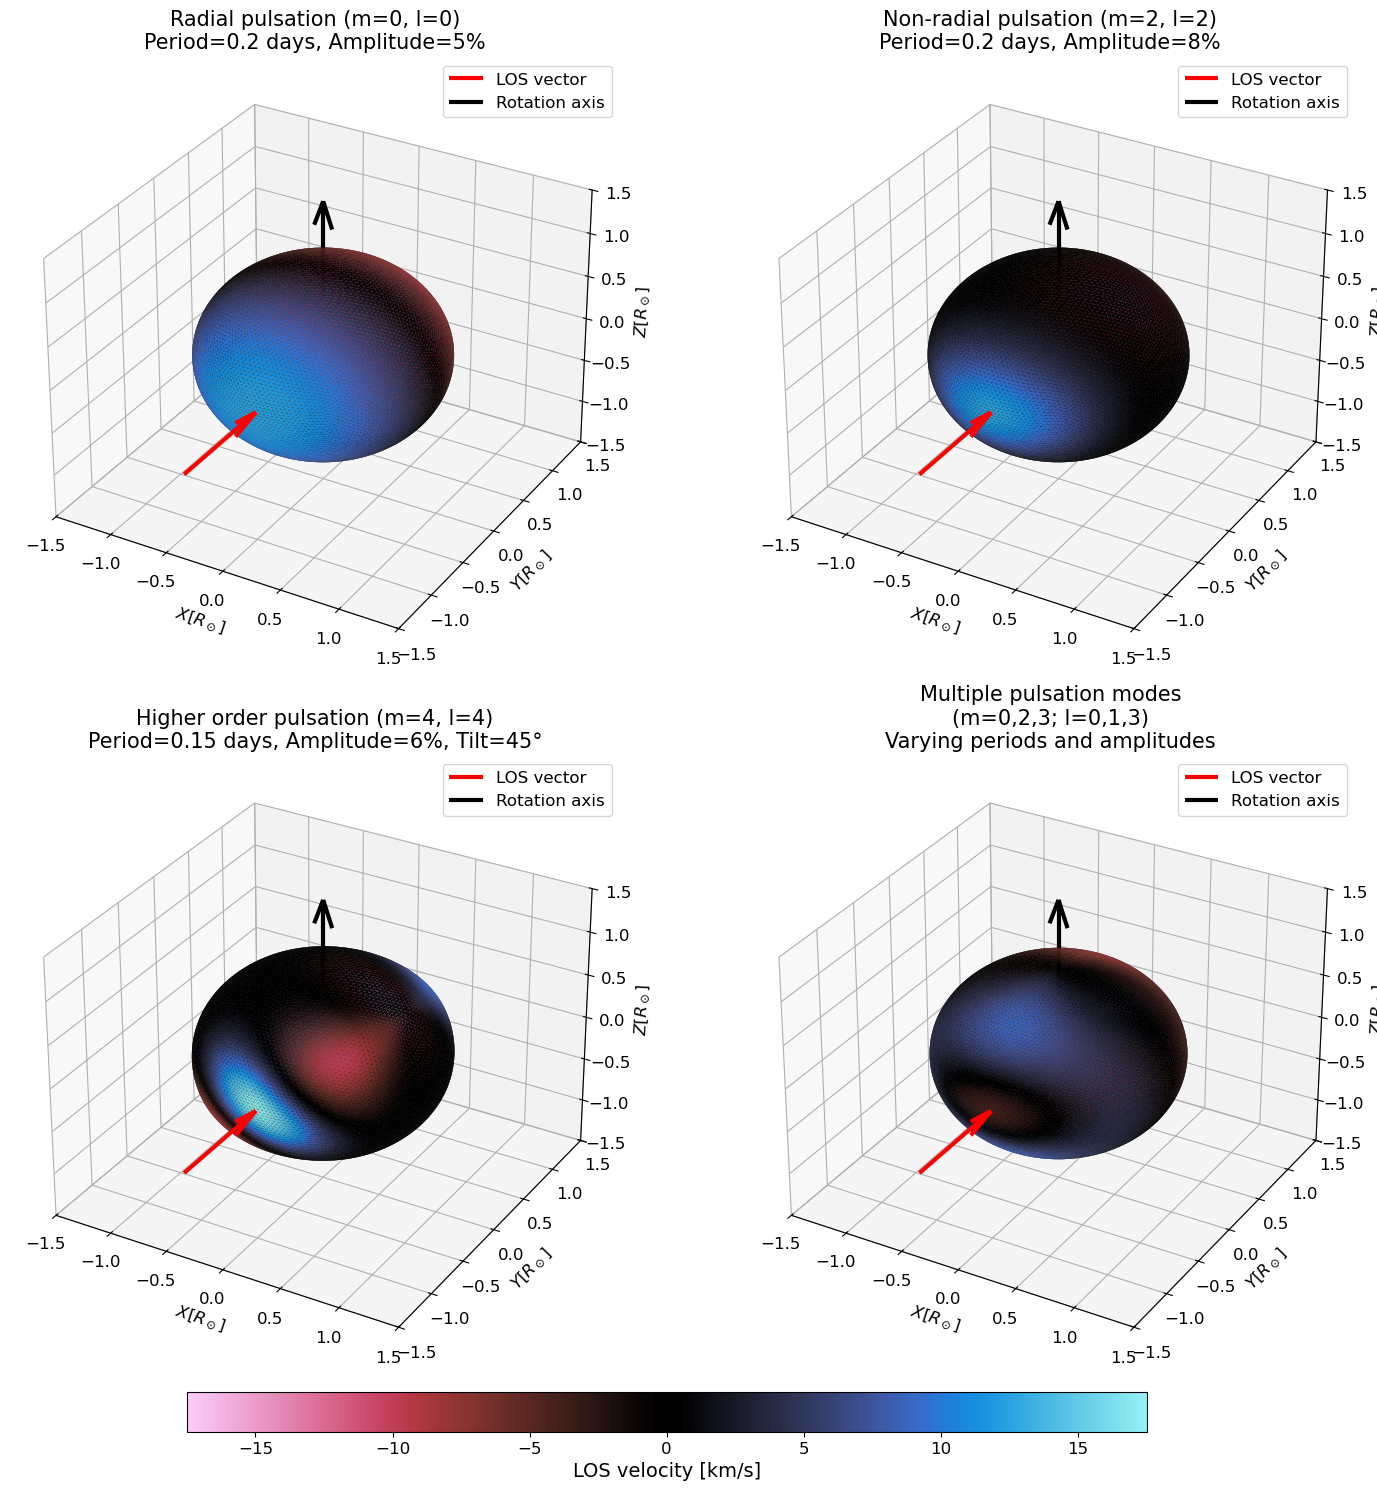

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d

from spice.models import IcosphereModel
from transformer_payne import Blackbody
from spice.models.mesh_transform import add_pulsation, add_pulsations, evaluate_pulsations

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Blackbody parameterization
bb = Blackbody()
base_temp = 5700

# Base icosphere model for all configs
m = IcosphereModel.construct(20000, 1., 1., bb.to_parameters(dict(teff=base_temp)), bb.parameter_names)
EV_TIME = 0.05

# --- Calculate all the pulsation models first ---
# Config 1: radial
m1 = add_pulsation(m, m_order=jnp.array([0]), l_degree=jnp.array([0]), period=jnp.array([0.2]),
                   fourier_series_parameters=jnp.array([[0.05, 0.0]]))
m1_eval = evaluate_pulsations(m1, EV_TIME)
los1 = m1_eval.los_velocities

# Config 2: non-radial (m=2, n=2)
m2 = add_pulsations(m, m_orders=jnp.array([2]), l_degrees=jnp.array([2]), periods=jnp.array([0.2]),
                    fourier_series_parameters=jnp.array([[0.05, 0.0]]))
m2_eval = evaluate_pulsations(m2, EV_TIME)
los2 = m2_eval.los_velocities

# Config 3: higher order (m=4, n=4, tilt 45 deg)
m3 = add_pulsations(
    m,
    m_orders=jnp.array([4]),
    l_degrees=jnp.array([4]),
    periods=jnp.array([0.15]),
    fourier_series_parameters=jnp.array([[0.06, 0.0]]),
    pulsation_axes=jnp.array([[0.0, 1.0, 0.0]]),
    pulsation_angles=jnp.array([45.0])
)
m3_eval = evaluate_pulsations(m3, EV_TIME)
los3 = m3_eval.los_velocities

# Config 4: multiple modes
m4 = add_pulsations(
    m,
    m_orders=jnp.array([0,2,3]),
    l_degrees=jnp.array([0,1,3]),
    periods=jnp.array([0.15, 0.1, 0.2]),
    fourier_series_parameters=jnp.array([[0.03, 0.0], [0.04, 0.0], [0.05, 0.0]])
)
m4_eval = evaluate_pulsations(m4, EV_TIME)
los4 = m4_eval.los_velocities

# --- Compute global min/max for normalization ---
all_los = np.concatenate([np.asarray(los1), np.asarray(los2), np.asarray(los3), np.asarray(los4)])
cmin = np.nanmin(all_los)
cmax = np.nanmax(all_los)

# --- Begin manual 3D plotting (instead of plot_3D) as in plot_mesh.py logic ---

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2,2,1,projection='3d'), fig.add_subplot(2,2,2,projection='3d')],
    [fig.add_subplot(2,2,3,projection='3d'), fig.add_subplot(2,2,4,projection='3d')]
]

cmap = 'cmr.redshift_r'
property_label = "LOS velocity [km/s]"

models = [m1_eval, m2_eval, m3_eval, m4_eval]
titles = [
    "Radial pulsation (m=0, l=0)\nPeriod=0.2 days, Amplitude=5%",
    "Non-radial pulsation (m=2, l=2)\nPeriod=0.2 days, Amplitude=8%",
    "Higher order pulsation (m=4, l=4)\nPeriod=0.15 days, Amplitude=6%, Tilt=45°",
    "Multiple pulsation modes\n(m=0,2,3; l=0,1,3)\nVarying periods and amplitudes"
]
plot_axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
mappables = []

for k, (mod, ax, title) in enumerate(zip(models, plot_axes, titles)):
    mesh = mod
    # Get the property to map
    prop = mesh.los_velocities
    # Set up colormap normalization
    norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

    # Set up axes limits and labels
    axes_lim = 1.5 * mesh.radius
    ax.set_xlim3d(-axes_lim, axes_lim)
    ax.set_ylim3d(-axes_lim, axes_lim)
    ax.set_zlim3d(-axes_lim, axes_lim)
    ax.set_xlabel('$X [R_\\odot]$', fontsize=12)
    ax.set_ylabel('$Y [R_\\odot]$', fontsize=12)
    ax.set_zlabel('$Z [R_\\odot]$', fontsize=12)

    # Draw LOS vector
    if hasattr(mesh, 'los_vector'):
        normalized_los_vector = mesh.los_vector / np.linalg.norm(mesh.los_vector)
        ax.quiver(*(-2.0 * mesh.radius * normalized_los_vector),
                  *(mesh.radius * normalized_los_vector),
                  color='red', linewidth=3., label='LOS vector')
    # Draw rotation axis
    if hasattr(mesh, 'rotation_axis'):
        arrow_color = 'black'
        if plt.style.available and plt.rcParams['axes.facecolor'] == 'black':
            arrow_color = 'white'
        normalized_rotation_axis = mesh.rotation_axis / np.linalg.norm(mesh.rotation_axis)
        ax.quiver(*(0.75 * mesh.radius * normalized_rotation_axis),
                  *(mesh.radius * normalized_rotation_axis),
                  color=arrow_color, linewidth=3., label='Rotation axis')
    # Add legend if vectors were drawn
    ax.legend()

    # Plot mesh faces colored by LOS velocity (property)
    vs2 = mesh.mesh_elements
    face_colors = mpl.colormaps[cmap](norm(prop))
    p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", linewidths=0.01)
    ax.add_collection(p)
    mappable.set_array(prop)
    mappables.append(p)
    ax.set_title(title, fontsize=15)

# Place one shared horizontal colorbar for all plots at the bottom
fig.subplots_adjust(bottom=0.18, top=0.95, left=0.05, right=0.98)
# The ScalarMappable requires set_array to work with colorbar; just use the min/max object.
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
# Use fig.add_axes to manually specify a horizontal colorbar at the bottom:
cbar_height = 0.025
cbar_width = 0.6
cbar_left = 0.19
cbar_bottom = 0.10
cbar_ax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(property_label, fontsize=14)

plt.tight_layout(rect=[0, 0.13, 1, 1])


In [13]:
fig.savefig('pulsations_harmonic.png', dpi=300, bbox_inches='tight')